<a href="https://colab.research.google.com/github/invegat/mlpstocks/blob/main/MLPStock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**File:** MLPStock.ipynb

**Mark Oliver
**Adapted from the LinkedIn Course: Data Science Foundations: Data Mining in Python file MLP.ipynb and from
**https://medium.com/@Matthew_Frank/stock-price-prediction-using-transformers-2d84341ff213
**file StockPricePredictionUsingTransformers.ipynb
**https://colab.research.google.com/drive/1j3AYSIxhiNJSCP692pKPbLk4_-kG4Pmh?usp=sharing

https://stackoverflow.com/questions/61163759/tuning-mlpregressor-hyper-parameters

# IMPORT LIBRARIES

In [1]:
%pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
import datetime as dt
# import itertools
# from itertools import product
import matplotlib.dates as mdates
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
import pytz
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings('ignore')

In [3]:
def calculate_bollinger_bands(data, window=35, num_of_std=2):
    """Calculate Bollinger Bands"""
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    # print(f'rolling_mean {rolling_mean}   rolling_str {rolling_std}')
    upper_band = rolling_mean + (rolling_std * num_of_std)
    lower_band = rolling_mean - (rolling_std * num_of_std)
    return upper_band, lower_band

def calculate_rsi(data, window=35):
    """Calculate Relative Strength Index"""
    delta = data.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_roc(data, periods=35):
    """Calculate Rate of Change."""
    roc = ((data - data.shift(periods)) / data.shift(periods)) * 100
    return roc

In [4]:
tickers = ["AAPL", "MSFT", "AMZN", "NVDA", "TSLA", "GOOG", "GOOGL",  "BRK-B","META",\
          "UNH", "V", "XOM", "JPM", "JNJ", "WMT", "MA", "PG", "CVX", "HD", "LLY", "ABBV", \
         "BAC", "MRK", "AVGO", "KO", "ORCL", "PEP", "PFE", "TMO", "COST", "QQQ", "CRWD", "TTD"]

In [5]:
print(len(tickers))

33


In [6]:
ticker_data_frames = []
stats = {}
ticker_mean = []
ticker_std = []
ticker_ndf = []
time = None
for ticker in tickers:

    # Download historical data for the ticker
    data = yf.download(ticker, period="1mo", interval="2m", timeout=50, repair=True)

    # Calculate the daily percentage change

    close = data['Close']
    upper, lower = calculate_bollinger_bands(close, window=14, num_of_std=5)
    # print(f'upper {upper}   lower {lower}')
    width = upper - lower
    rsi = calculate_rsi(close, window=14)
    roc = calculate_roc(close, periods=14)
    volume = data['Volume']
    diff = data['Close'].diff(1)
    percent_change_close = data['Close'].pct_change() * 100
    percent_change_close = percent_change_close.values.reshape(-1)
    if time is None:
        time = data.index

    # Create a DataFrame for the current ticker and append it to the list
    ticker_df = pd.DataFrame({
        ticker+'_close': close.values.reshape(-1),
        ticker+'_width': width.values.reshape(-1),
        ticker+'_rsi': rsi.values.reshape(-1),
        ticker+'_roc': roc.values.reshape(-1),
        ticker+'_volume': volume.values.reshape(-1),
        ticker+'_diff': diff.values.reshape(-1),
        ticker+'_percent_change_close': percent_change_close,
    })

    MEAN = ticker_df.mean()
    STD = ticker_df.std()

    # Keep track of mean and std
    for column in MEAN.index:
      stats[f"{column}_mean"] = MEAN[column]
      stats[f"{column}_std"] = STD[column]

    # Normalize the training features
    # ticker_df = (ticker_df - MEAN) / STD
    ticker_ndf.append((ticker_df - MEAN) / STD)
    ticker_mean.append(MEAN)
    ticker_std.append(STD)

    ticker_data_frames.append(ticker_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [7]:
local_timezone = pytz.timezone('America/New_York') # Replace with your local timezone
local_time = time.tz_convert(local_timezone)
date = time[0].date()
dates_ = [date]
for t in local_time:
    if t.date() != date:
        dates_.append(t.date())
        date = t.date()
dates = np.array(dates_)
# test = np.arange(dates[len(dates)-5], dates[len(dates)-1])
# test

In [8]:
stats = pd.DataFrame([stats], index=[0])
stats.head()

,AAPL_close_mean,AAPL_close_std,AAPL_width_mean,AAPL_width_std,AAPL_rsi_mean,AAPL_rsi_std,AAPL_roc_mean,AAPL_roc_std,AAPL_volume_mean,AAPL_volume_std,...,TTD_rsi_mean,TTD_rsi_std,TTD_roc_mean,TTD_roc_std,TTD_volume_mean,TTD_volume_std,TTD_diff_mean,TTD_diff_std,TTD_percent_change_close_mean,TTD_percent_change_close_std
0,249.290544,4.804926,2.280693,2.119178,51.031352,16.557855,0.005724,0.298279,158727.444444,298190.32226,...,48.976421,16.923962,-0.049114,0.538733,13515.367383,20415.643577,-0.004166,0.19061,-0.003201,0.146943


- Use the mean squared error (MSE) as cross-validation loss.

In [9]:
def mlp_model(X, Y):

    max_iter = 30000

    # estimator=MLPRegressor(max_iter=max_iter, n_iter_no_change=20)
    # kerasModel = tf1.keras.estimator.model_to_estimator(estimator).model

    # opt = keras.optimizers.Adam()
    # model = Sequential()
    #             # model.add(LSTM(units=50,return_sequences=True,activation='relu'))
    # model.add(LSTM(units=1, return_sequences=True))#,    input_shape= (input_length, input_dim)))

    # # model.add(kerasModel)
    # model.add(Dense(units=6 * 390 / interval)) # 6 trading days away
    #             # model.add(Activation('linear'))
    # model.compile(optimizer=opt,loss='mse', metrics=['mse'])



    # params = np.arange(50,75,1)
    # jls = [(p,2*p,p,) for p in params]
    # param_grid = {'hidden_layer_sizes': jls,
    #       'activation': ['relu','tanh','logistic'],
    #       'alpha': [0.05, 0.25, 0.5],
    #       'learning_rate': ['constant','adaptive'],
    #       'solver': ['adam'],
    #        'batch_size':[16,32,64],
    #         'shuffle': [False]
    #              }
    # param_grid = {
    #     'units': [10,50,100,200,300 ],
    #     'activation': ['relu','tanh','logistic'],
    #     'learning_rate':[0.001, 0.01, 0.1, 0.5],
    # }
    # gsc = GridSearchCV(
    # model,
    # param_grid,
    # cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    # grid_result = gsc.fit(X, Y)


    # best_params = grid_result.best_params_

    best_mlp = MLPRegressor(hidden_layer_sizes = [62,62,62,62,62,62],
                            alpha=0.025,
                            batch_size=16,
                        activation ="tanh",
                        solver="adam",
                        learning_rate='adaptive',
                        learning_rate_init=0.005,
                        max_iter= max_iter, n_iter_no_change = 60
              )

    # opt = keras.optimizers.Adam(learning_rate=best_params['learning_rate'])

    # model = Sequential()
    #             # model.add(LSTM(units=50,return_sequences=True,activation='relu'))
    # model.add(LSTM(units=best_param['units'],return_sequences=True,activation=best_params['activation'])) #,    input_shape= (input_length, input_dim)))

    # # model.add(tf1.estimator.model_to_estimator(best_mlp).model)
    # model.add(Dense(units=6 * 390 / interval)) # 6 trading days away
    #             # model.add(Activation('linear'))
    # model.compile(optimizer=opt,loss='mse', metrics=['mse'])

    # # model_dir = tempfile.mkdtemp()
    # keras_estimator = tf1.estimator.model_to_estimator(
    #     keras_model=model,
    #     model_dir=model_dir
    # )


    scoring = {
           'abs_error': 'neg_mean_absolute_error',
           'squared_error': 'neg_mean_squared_error',
           'r2':'r2'}

    # scores = cross_validate(keras_estimator, X, Y, cv=3, scoring=scoring, return_train_score=True, return_estimator = True, n_jobs=-1)
    scores = cross_validate(best_mlp, X, Y, cv=3, scoring=scoring, return_train_score=True, return_estimator = True, n_jobs=-1)
    return None,scores


In [10]:
scores = []
params_ = []

mean squared error 0.0009163446354041833


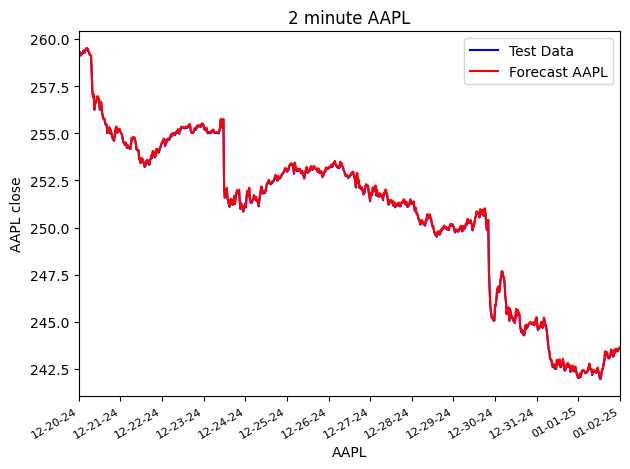

mean squared error 6.463624544698608e-05


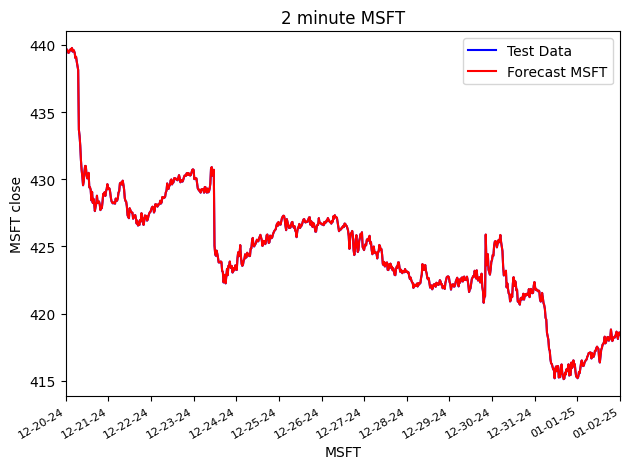

mean squared error 0.066216668234898


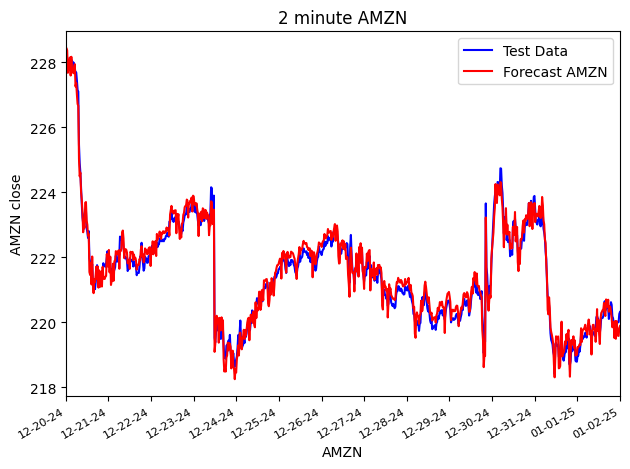

mean squared error 0.30481731133722145


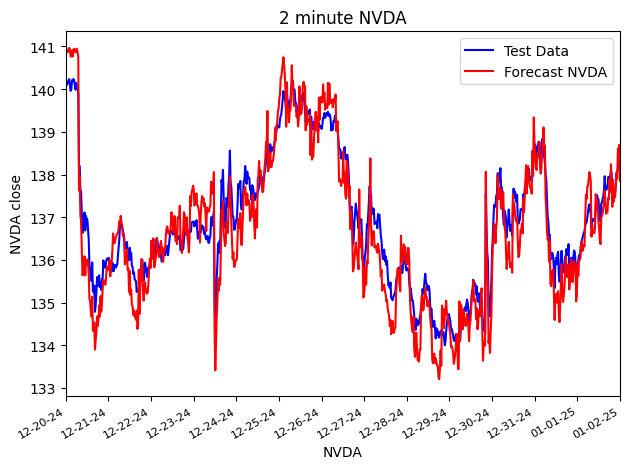

mean squared error 0.09432961465233781


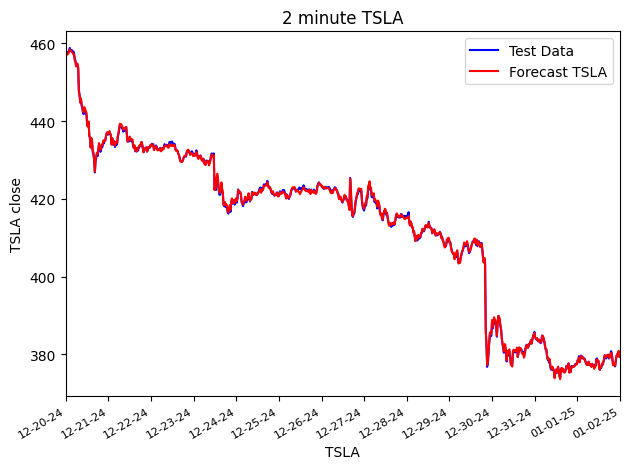

mean squared error 0.401497485216945


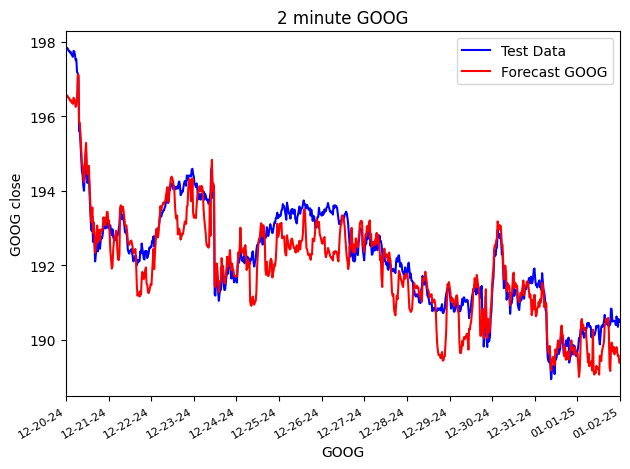

mean squared error 0.3626470075549674


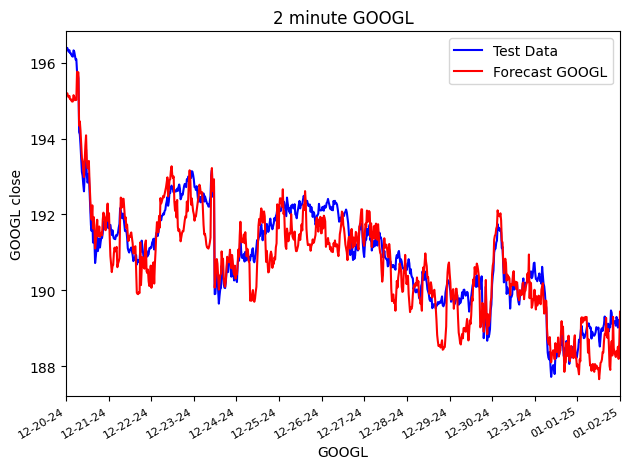

mean squared error 0.0005421464276495064


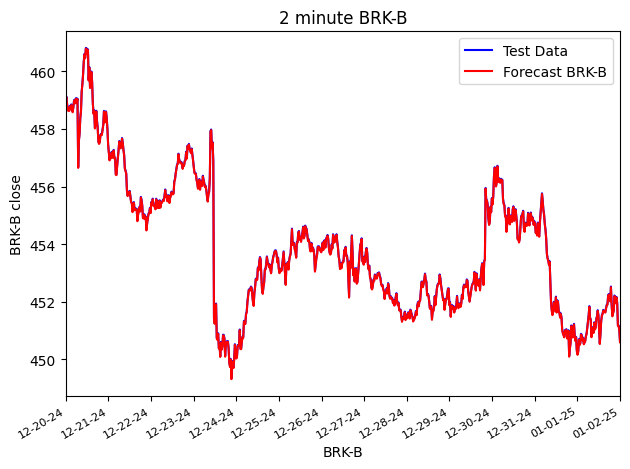

mean squared error 0.0022616561743000053


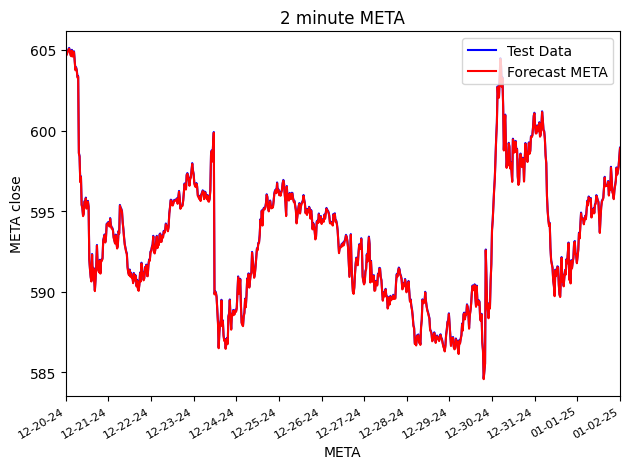

mean squared error 1.0067209126886236


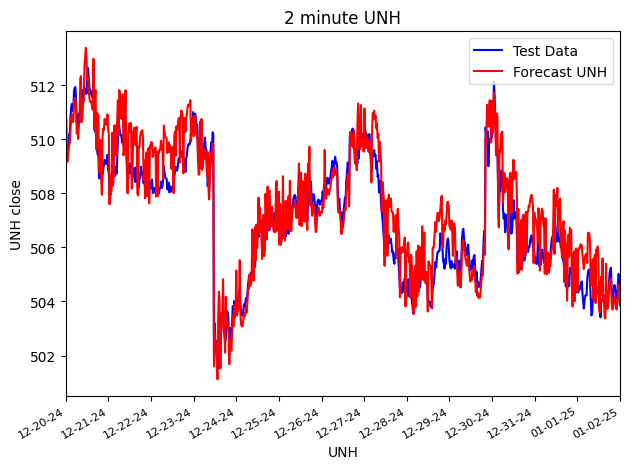

mean squared error 0.004583534175534496


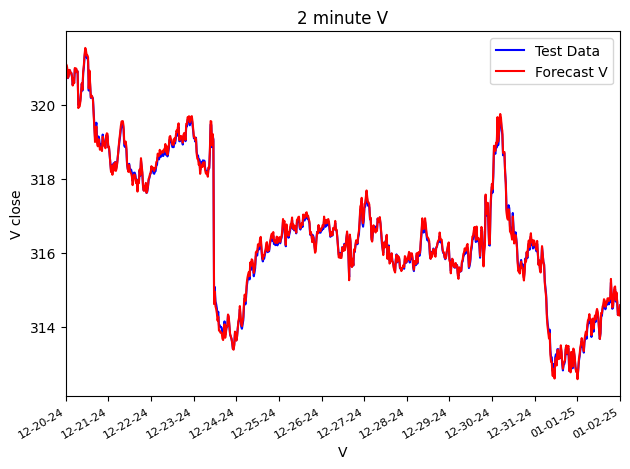

mean squared error 0.0004675150184327328


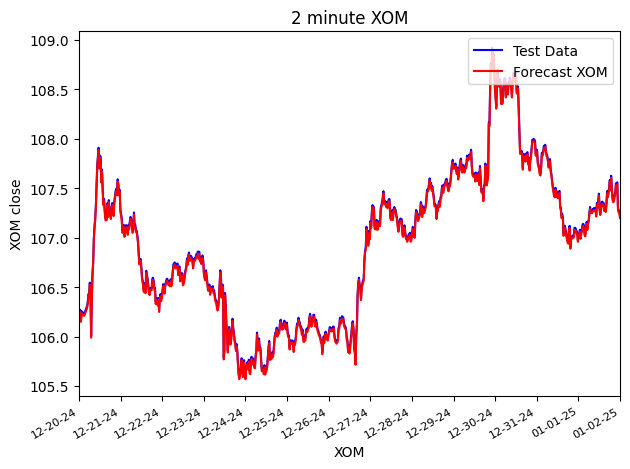

mean squared error 0.06770238697148111


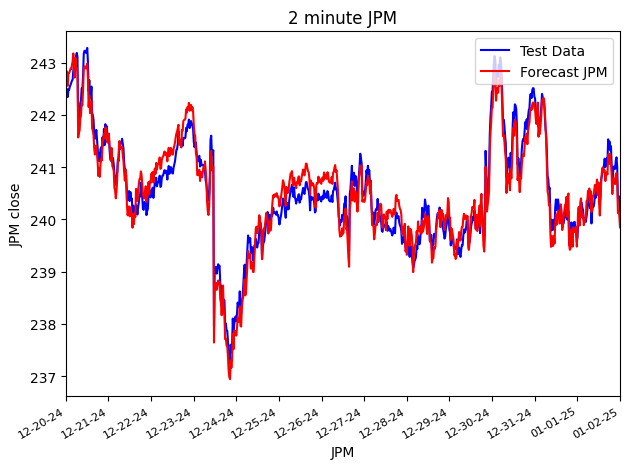

mean squared error 0.00048565841781957324


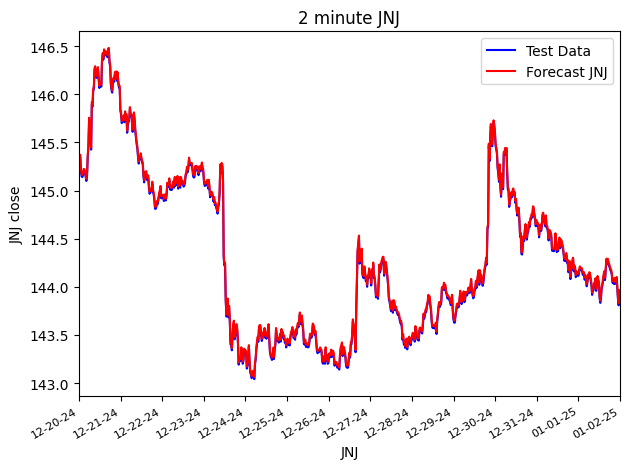

mean squared error 0.03984784577376719


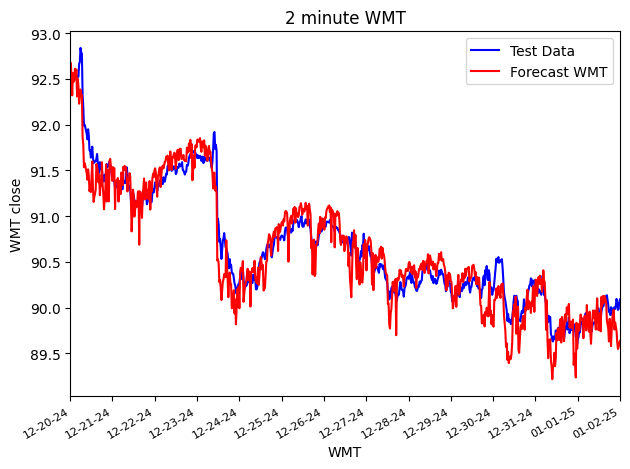

mean squared error 0.12808692571208583


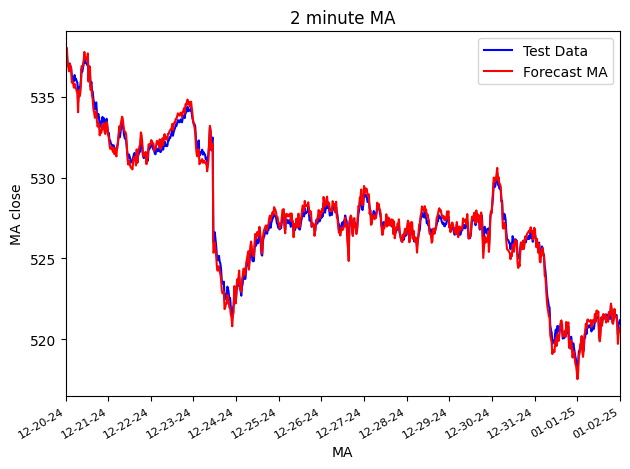

mean squared error 0.025236924488787008


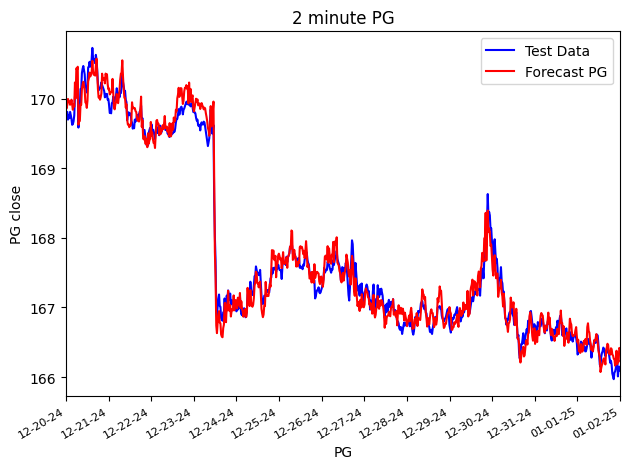

mean squared error 0.16736268615785613


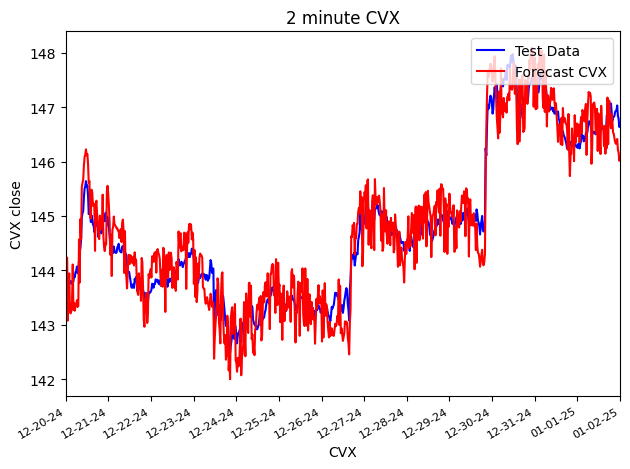

mean squared error 0.0736926112789168


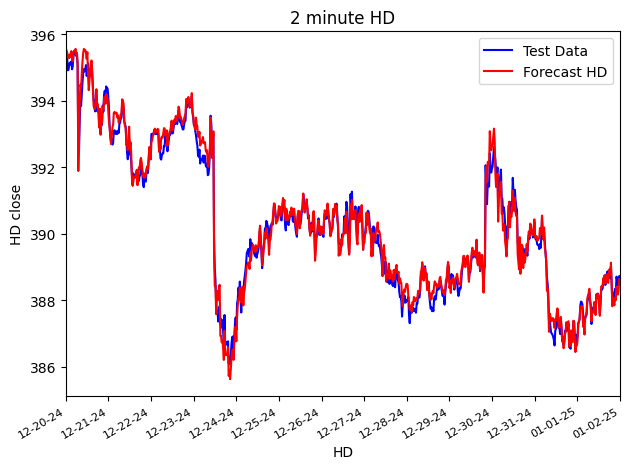

mean squared error 0.0009637026774531384


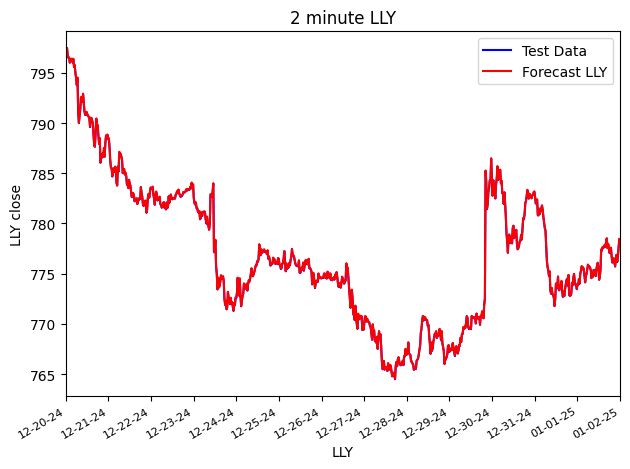

mean squared error 0.08232818803996841


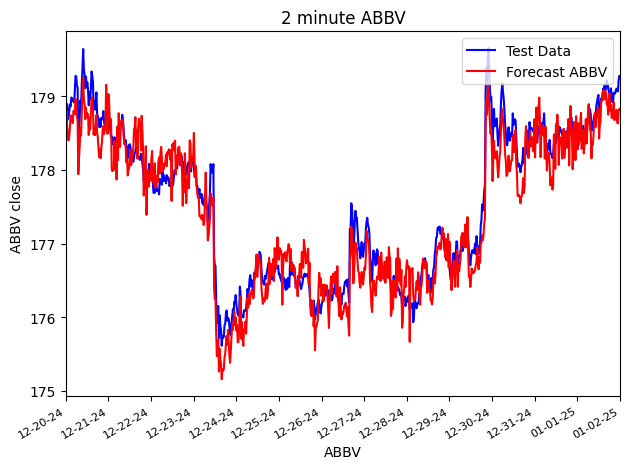

mean squared error 0.05616766699386718


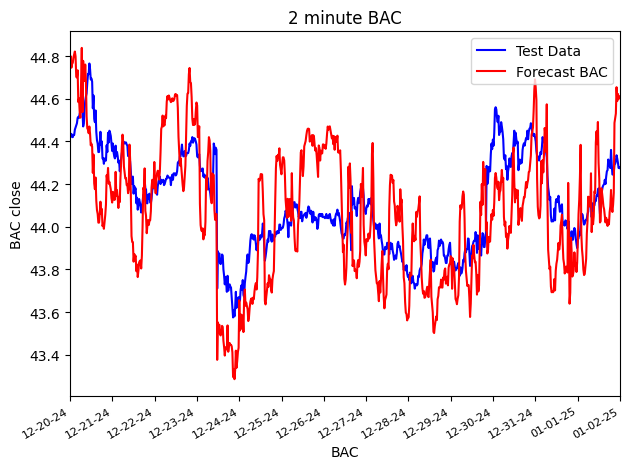

mean squared error 0.0022407283035006053


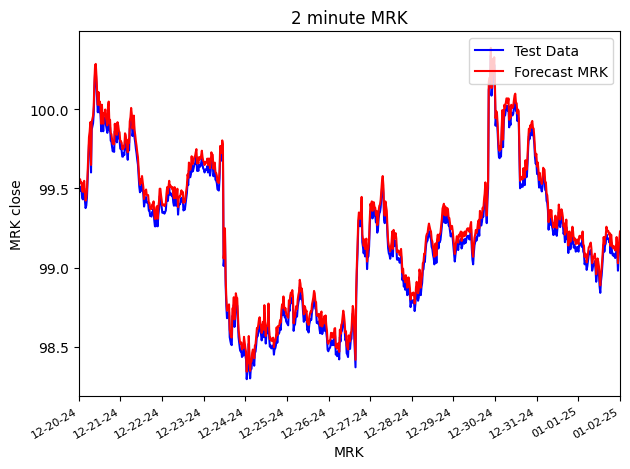

mean squared error 0.6810609810265378


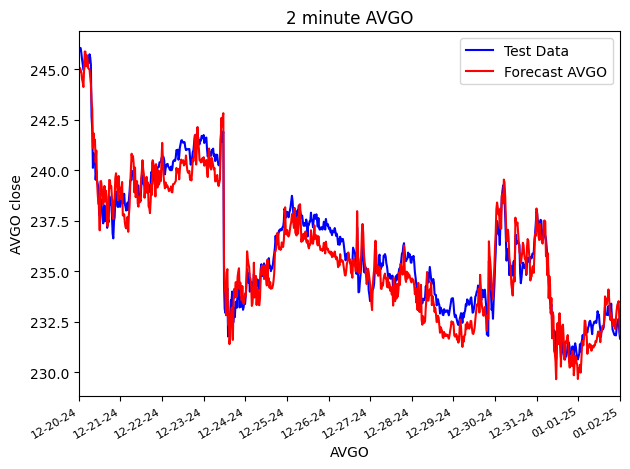

mean squared error 0.0296838154818724


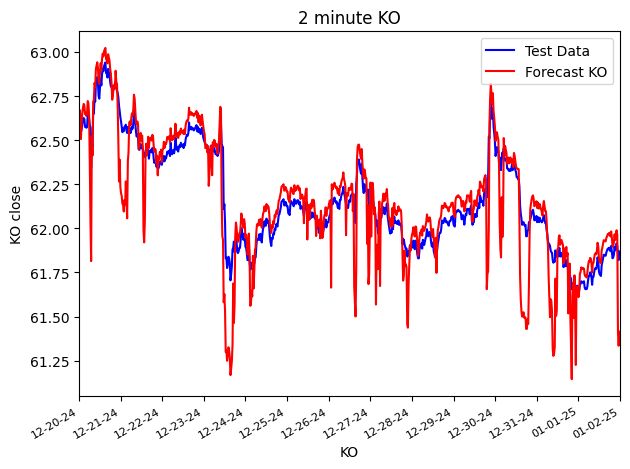

mean squared error 0.0635611496792064


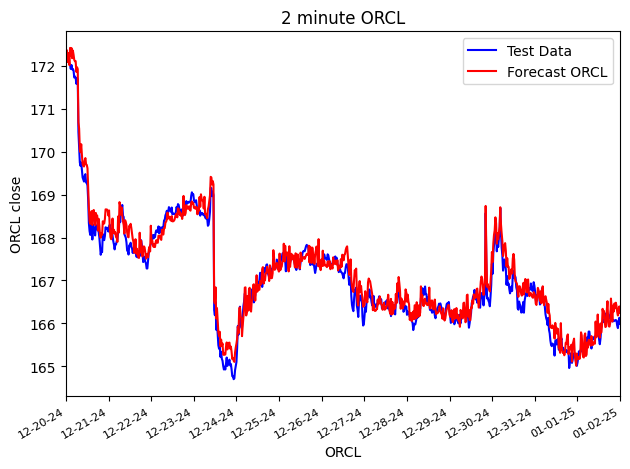

mean squared error 0.0004181086364513162


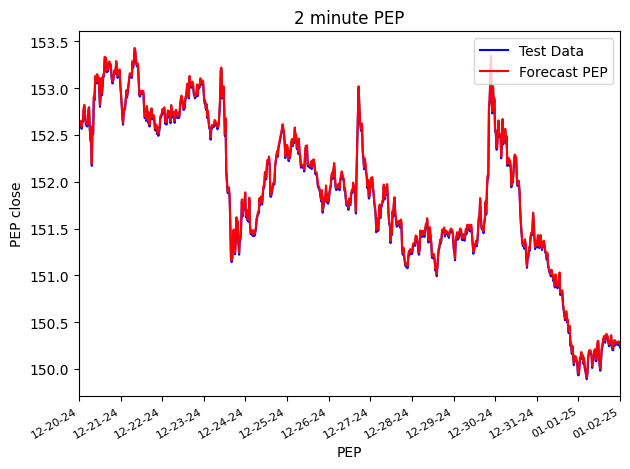

mean squared error 2.7050675961820914e-05


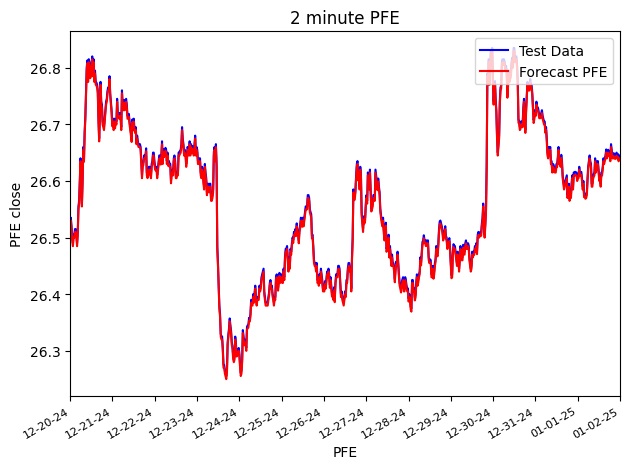

mean squared error 3.210915039996446e-05


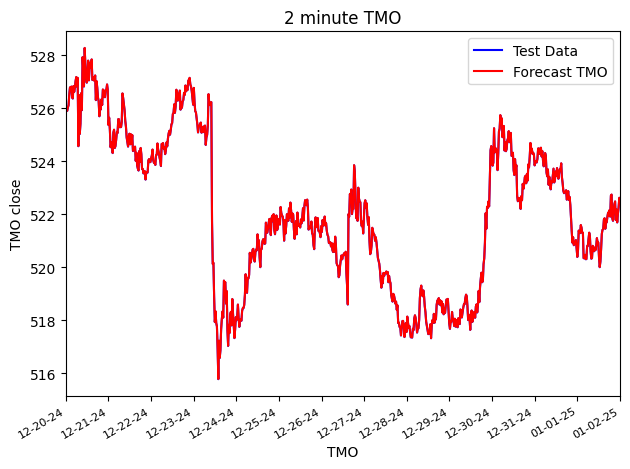

mean squared error 0.03965811450603056


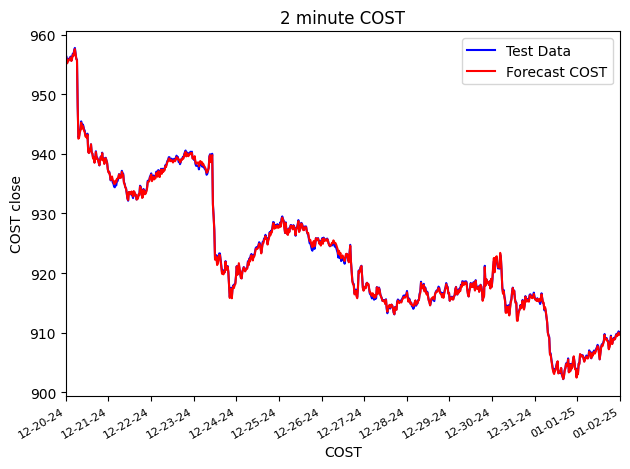

mean squared error 0.031421713473353166


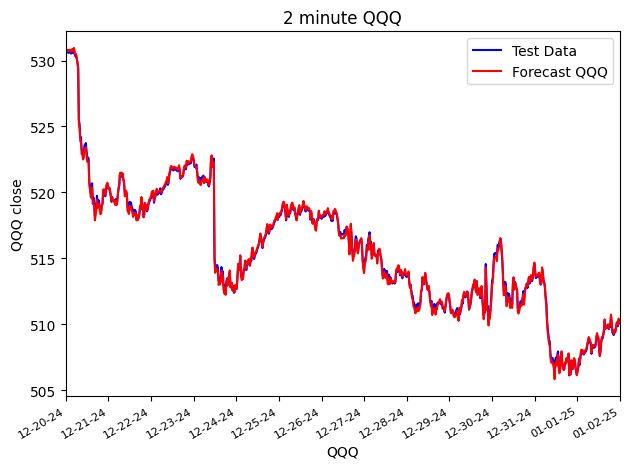

mean squared error 6.896423741448855e-05


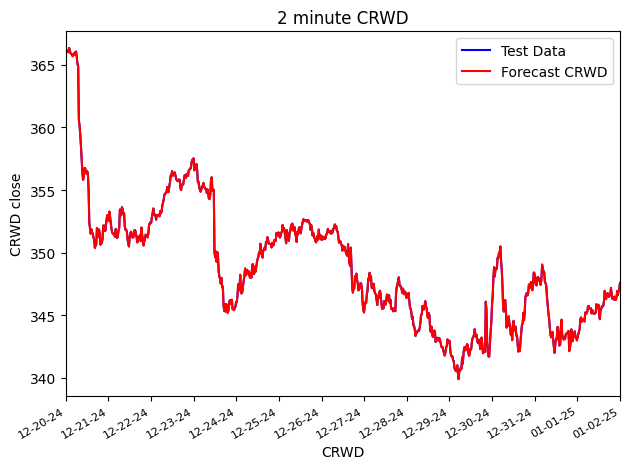

mean squared error 0.0004937709340387346


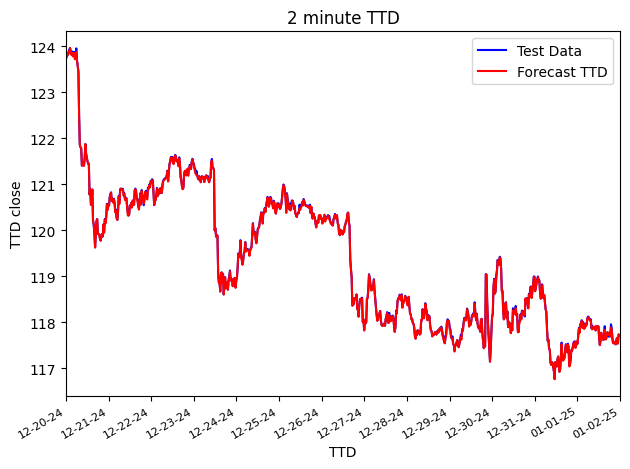

total_mse 3.735605934978531   average mse 0.11320017984783427


In [11]:
k = 5
total_mse = 0

for i,odf in enumerate(ticker_data_frames):
    # mean_close = ticker_mean[i]
    # mean_std = ticker_std[i]
    # odf = (odf + mean_close) * mean_std
    columns = list(odf.columns.values)
    newColumns = columns[1:k]
    newColumns.append(columns[0])
    # print(f'odf.shape {odf.shape}')
    df = odf[newColumns]
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    df = df.iloc[:-1]
    # print(f'df.shape {df.shape}')
    # print(df.head())
    Z = df.to_numpy()
    split = np.int32(0.8 * Z.shape[0])
    Z_train, Z_test = Z[:split, :], Z[split:, :]
    # Z_train, Z_test = Z[:,split], Z[split:, :]
    # print(f'len Z_trian {Z_train.shape}    len Z_test {Z_test.shape}  len Z {Z.shape}')
    train_scaler = StandardScaler().fit(Z_train)



    Z_train = train_scaler.transform(Z_train)

    y_scaler = StandardScaler().fit(Z_test[:,-1].reshape(1, -1))  # y_test
    test_scaler = StandardScaler().fit(Z_test)
    Z_test__ = test_scaler.transform(Z_test)
    X_train, y_train = Z_train[:, :-1], Z_train[:, -1]
    X_test, _ = Z_test__[:, :-1], Z_test[:, -1]
    # y_test = y_scaler.transform(Z_test[:,-1].reshape(1, -1))
    y_test = Z_test[:,-1]
    # print(f'y_test {y_test}')
    # print(f'Z_test[:,-1] {Z_test[:,-1]}')
    # displayXY(ssX_train[:,0], X_train[:,0], "ss vs StandardScaler Train X", i)
    # displayXY(ssY_train, y_train, "ss vs StandardScaler Train y", i)
    # displayXY(ssX_test[:,0], X_test[:,0], "ss vs StandardScaler Text X", i)
    # displayXY(ssY_test, y_test, "ss vs StandardScaler Test Y", i)
    # print(f'len X_trian {len(X_train)}    len y_test {len(y_test)}')
    params, score= mlp_model(X_train, y_train)
    params_.append(params)
    scores.append(score)
    # score=scores[0]
    # params=params_[0]
    # y_pred = None
    # for i_,e in enumerate(score['estimator']):
    #     e.fit(X_train, y_train)
    #     pred = e.predict(X_test)
    #     if i_ == 0:
    #         y_pred = np.array(pred)
    #     else:
    #         y_pred += np.array(pred)
    # y_pred /= len(score['estimator'])
    e = score['estimator'][np.argmin(score['train_squared_error'])]
    e.fit(X_train,y_train)


    # mlp = MLPRegressor(hidden_layer_sizes = params["hidden_layer_sizes"],
    #                 activation =params["activation"],
    #                 solver=params["solver"],
    #                 max_iter= 5000, n_iter_no_change = 200

    # params = [10,15, 16, 17, 18, 19 ,20,21,22,23,24,25,30,35,40,45,50,55,60,65,75]
    # params = np.arange(10,25,1)
    # mse = [cross_validation_loss(p, X_train,y_train) for p in params]
    # minMSE = params[np.argmin(mse)]
    # mlp = MLPRegressor(hidden_layer_sizes=(2*minMSE,minMSE,minMSE,), max_iter=5000, random_state=1,
    #                    activation='relu', learning_rate_init=0.001, alpha=0.00001,shuffle=False)
    # print(f'minMSE: {minMSE}  df.shape {df.shape} {stats.iloc[0][0:2]} {stats.iloc[0][0]}    {stats.iloc[0][1]}')
    # close = odf.columns.to_list()[0]
    # mlp.fit(X_train, y_train)
    y_pred = e.predict(X_test )
    # y_test_ = (test_scaler.inverse_transform(np.hstack([X_test, y_test.reshape(-1, 1)]))[:, -1])
    # y_pred_ = (test_scaler.inverse_transform(np.hstack([X_test, y_pred.reshape(-1, 1)]))[:, -1])
    # y_test_ = (y_scaler.inverse_transform(np.hstack([X_test, y_test.reshape(-1, 1)]))[:, -1])
    # y_pred_ = (y_scaler.inverse_transform(np.hstack([X_test, y_pred.reshape(-1, 1)]))[:, -1])
    # y_test_ = y_scaler.inverse_transform(np.array(y_test))[0]
    y_test_ = y_test
    # print(f'y_test_.shape {y_test_.shape}')
    y_pred_ = y_scaler.inverse_transform(np.array(y_pred.reshape(1, -1)))[0]
    # print(f'y_pred_.shape {y_pred__.shape}')
    mse_ = mean_squared_error(y_test_, y_pred_)
    total_mse += mse_
    print(f'mean squared error {mse_}')
    fig, ax = plt.subplots()
    plt.xlabel(tickers[i])
    plt.ylabel(f'{tickers[i]} close')
    plt.title(f'2 minute {tickers[i]}')
    time = mdates.drange(dates[len(dates)-np.round(len(y_test_)/97.5).astype(int)],dates[len(dates)-1],  dt.timedelta(hours=3.25))
    fractions = np.linspace(min(time), max(time), len(y_test_))
    plt.plot(fractions, pd.Series(y_test_), color='blue', label='Test Data')
    plt.plot(fractions, pd.Series(y_pred_), color='red', label=f'Forecast {tickers[i]}')
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%y"))
    plt.xlim(min(time), max(time))
    plt.xticks(time, fontsize=8)
    ax.xaxis_date() # Default date formatter
    fig.autofmt_xdate()
    plt.legend(loc='upper right')
    # plt.figure(figsize=(15, 5))
    ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.tight_layout()
    plt.show()
    # if i == 5:
    #     break
print(f'total_mse {total_mse}   average mse {total_mse/len(ticker_data_frames)}')

In [ ]:
?e.predict

Object `e.predict` not found.
